In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

/mnt/lun1/home/dbw/anaconda3/envs/cvnets/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE=512 # 批次大小
EPOCHS=25 # 总共训练批次
DEVICE='cpu'

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 9, 11, padding=5) # 28x28
        self.pool1 = nn.MaxPool2d(2, 2) # 14x14
        self.conv2 = nn.Conv2d(12, 21, 7,padding = 1) # 10x10
        self.pool2 = nn.MaxPool2d(2, 2) # 5x5
        self.conv3 = nn.Conv2d(24, 120, 7,padding = 1)
        self.conv11 = nn.Conv2d(6, 24, 5)
        self.conv12 = nn.Conv2d(6, 120, 5)
        self.conv21 = nn.Conv2d(12, 120, 5)
        self.fc1 = nn.Linear(9504, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        in_size = x.size(0)
        old = x
        out = torch.cat([x, old], dim=1)
        out12 = self.conv12(out)
        out = self.conv1(out) # 24
        out = F.relu(out)
        out = self.pool1(out)  # 12

        transform = transforms.Resize((out.shape[2], out.shape[2]))
        old = transform(x)
        out = torch.cat([out, old], dim=1)
        out21 = self.conv21(out)
        
        out = self.conv2(out) # 10
        out = F.relu(out)
        out = self.pool2(out)

        transform = transforms.Resize((out.shape[2], out.shape[2]))
        old = transform(x)
        out12 = transform(out12)
        out21 = transform(out21)
        out = torch.cat([out, old], dim=1)
        residual3 = self.conv3(out)

        out = torch.cat([out, out12, out21], dim=1)
        out = out.view(in_size, -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.log_softmax(out, dim=1)
        return out


In [4]:
def train(model, device, train_loader, optimizer, epoch, train_losses, train_counter):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if(batch_idx+1)%30 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [5]:
def test(model, device, test_loader, test_losses, test_counter, test_accuracy):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output0 = model(data)
            test_loss += F.nll_loss(output0, target, reduction='sum').item() # 将一批的损失相加
            pred = output0.max(1, keepdim=True)[1] # 找到概率最大的下标
            
            # output1 = model(data)
            # output2 = model(data)
            # pred1 = output1.max(1, keepdim=True)[1] # 找到概率最大的下标
            # pred2 = output2.max(1, keepdim=True)[1] # 找到概率最大的下标
            # pred = Counter([pred0,pred1,pred2]).most_common(1)[0][0]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_counter.append(len(test_losses))
    test_accuracy.append(100. * correct / len(test_loader.dataset))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [6]:
model = ConvNet()
optimizer = optim.Adam(model.parameters())

In [7]:
if __name__ == "__main__":
    train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
            batch_size=BATCH_SIZE, shuffle=True)


    test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
            batch_size=BATCH_SIZE, shuffle=True)


    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = []
    test_accuracy = []
    # # 加载模型参数
    # model.load_state_dict(torch.load('LeNet.pth'))
    for epoch in range(1, EPOCHS + 1):
        train(model, DEVICE, train_loader, optimizer, epoch, train_losses, train_counter)
        test(model, DEVICE, test_loader, test_losses, test_counter, test_accuracy)

Files already downloaded and verified
Train Epoch: 1 [14848/50000 (30%)]	Loss: 1.884151
Train Epoch: 1 [30208/50000 (60%)]	Loss: 1.744359
Train Epoch: 1 [45568/50000 (91%)]	Loss: 1.650738

Test set: Average loss: 1.5727, Accuracy: 4414/10000 (44%)

Train Epoch: 2 [14848/50000 (30%)]	Loss: 1.513893
Train Epoch: 2 [30208/50000 (60%)]	Loss: 1.417500
Train Epoch: 2 [45568/50000 (91%)]	Loss: 1.415530

Test set: Average loss: 1.3907, Accuracy: 5085/10000 (51%)

Train Epoch: 3 [14848/50000 (30%)]	Loss: 1.394945
Train Epoch: 3 [30208/50000 (60%)]	Loss: 1.300355
Train Epoch: 3 [45568/50000 (91%)]	Loss: 1.318100

Test set: Average loss: 1.3366, Accuracy: 5241/10000 (52%)

Train Epoch: 4 [14848/50000 (30%)]	Loss: 1.152699
Train Epoch: 4 [30208/50000 (60%)]	Loss: 1.179597
Train Epoch: 4 [45568/50000 (91%)]	Loss: 1.140109

Test set: Average loss: 1.2275, Accuracy: 5631/10000 (56%)

Train Epoch: 5 [14848/50000 (30%)]	Loss: 1.141001
Train Epoch: 5 [30208/50000 (60%)]	Loss: 1.021436
Train Epoch: 5 [45

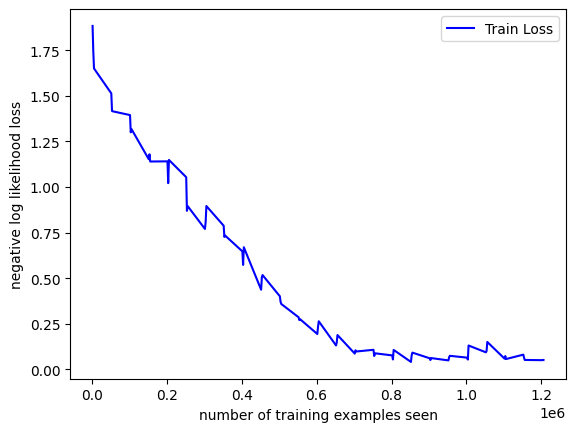

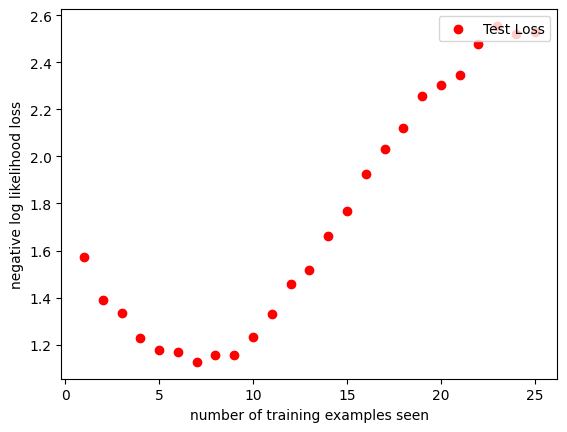

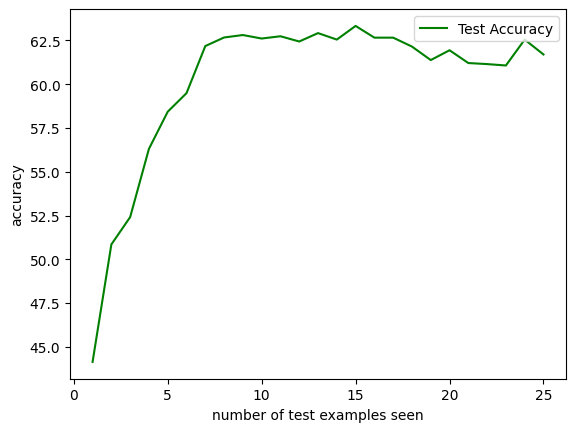

In [8]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')

plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

plt.show()
fig = plt.figure()
plt.scatter(test_counter, test_losses, color='red')
plt.legend([ 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

fig = plt.figure()
plt.plot(test_counter, test_accuracy, color='green')
plt.legend(['Test Accuracy'], loc='upper right')
plt.xlabel('number of test examples seen')
plt.ylabel('accuracy')
plt.show()

In [9]:
# 保存模型参数
torch.save(model.state_dict(), '_2DataEnhanceV2large.pth')